<a href="https://colab.research.google.com/github/MutugiD/Data-Problems/blob/master/Movie_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
from surprise import Reader
from surprise import Dataset
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import SVD
from surprise import SVDpp
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import CoClustering
from surprise import NMF
from surprise import SlopeOne
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict

Load the movielens-100k dataset

In [17]:
data = Dataset.load_builtin('ml-100k', prompt = False)

Create a benchmark. Iterate over SVD, NMF, NormalPredictor, KNNBasic 

In [18]:
benchmark = []
for algo in [SVD(), NMF(), NormalPredictor(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
    info = pd.DataFrame.from_dict(results).mean(axis=0)
    info = info.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(info)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [19]:
algo_data = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
algo_data

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.944447,4.058422,0.311620
NMF,0.976202,4.353553,0.273518
KNNBasic,0.990206,0.279518,5.293068
NormalPredictor,1.515411,0.117885,0.320336



Tunining algorithmic parameters to find the best fits by use of grid search

In [20]:
parameters= {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
grid= GridSearchCV(SVD, parameters, measures=['rmse', 'mae'], cv=3)
trainset, testset = train_test_split(data, test_size=0.2)
grid.fit(data)
algo_best = grid.best_estimator['rmse']
print(grid.best_score['rmse'])
print(grid.best_params['rmse'])

t_num = grid.best_params
factors = t_num['rmse']['n_factors']
epochs = t_num['rmse']['n_epochs']
lr_value = t_num['rmse']['lr_all']
reg_value = t_num['rmse']['reg_all']


0.9273949991891661
{'n_factors': 40, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.08}


In [21]:
trainset, testset = train_test_split(data, test_size=0.20)
algo_algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
predictions = algo_algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.9223


0.9223081866967705

Checking how good or bad the predictions are: 
UID: user-id

iid: item id

Rui: the rating given by the user

est: rating estimated by the model

Iu: No of items rated by the user

UI: number of users that have rated this item

err: abs difference between predicted rating and the actual rating.

In [36]:
#Gets the user_id, returns no of items rated by user
def get_Iu(uid):
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:
        return 0
#Gets raw id of an item, returns no of users who have rated the item
def get_Ui(iid):
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]


In [37]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
19874,617,424,1.0,1.0,{'was_impossible': False},88,15,0.0
5695,774,398,1.0,1.0,{'was_impossible': False},173,20,0.0
8632,774,1079,1.0,1.0,{'was_impossible': False},173,32,0.0
12757,774,545,1.0,1.0,{'was_impossible': False},173,9,0.0
17161,928,1007,5.0,5.0,{'was_impossible': False},24,35,0.0
19204,270,173,5.0,5.0,{'was_impossible': False},114,266,0.0
5546,628,302,5.0,5.0,{'was_impossible': False},21,234,0.0
17575,507,306,5.0,5.0,{'was_impossible': False},46,75,0.0
18480,181,424,1.0,1.0,{'was_impossible': False},354,15,0.0
11242,592,56,5.0,5.0,{'was_impossible': False},285,323,0.0


In [38]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
17040,697,1022,1.0,4.306887,{'was_impossible': False},84,26,3.306887
19328,272,133,1.0,4.368920,{'was_impossible': False},34,131,3.368920
6763,312,265,1.0,4.375665,{'was_impossible': False},164,184,3.375665
10478,405,842,5.0,1.513135,{'was_impossible': False},606,18,3.486865
4617,777,100,1.0,4.531984,{'was_impossible': False},27,399,3.531984
14126,239,64,1.0,4.559547,{'was_impossible': False},123,227,3.559547
16913,127,690,1.0,4.712927,{'was_impossible': False},18,127,3.712927
1045,127,268,1.0,4.758874,{'was_impossible': False},18,199,3.758874
19177,127,750,1.0,4.784178,{'was_impossible': False},18,100,3.784178
10610,850,98,1.0,4.916977,{'was_impossible': False},40,313,3.916977


Recommendations (Priotiy K items)


In deciding Relevant and Recommended: 

Relevant: True Rating > = 3.5

Irrelevant: True Rating < 3.5

Thus, the f1 score is: 

f1 score = 2 (precision recall) / (precision + recall)

Thus, calculation of TP,FP,TN,FN at every threshold level (0.0 - 5.0) with steps of 0.5



In [41]:
final_result = []

for threshold in np.arange(0, 5.5, 0.5):
  tp=0
  fn=0
  fp=0
  tn=0
  temp = []

  for uid, _, true_r, est, _ in predictions:
    if(true_r>=threshold):
      if(est>=threshold):
        tp = tp+1
      else:
        fn = fn+1
    else:
      if(est>=threshold):
        fp = fp+1
      else:
        tn = tn+1   

    if tp == 0:
      precision = 0
      recall = 0
      f1 = 0
    else:
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      f1 = 2 * (precision * recall) / (precision + recall)  

  temp = [threshold, tp,fp,tn ,fn, precision, recall, f1]
  final_result.append(temp)

result = pd.DataFrame(final_result)
result.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
result

,threshold,tp,fp,tn,fn,Precision,Recall,F1
0,0.0,20000,0,0,0,1.000000,1.000000,1.000000
1,0.5,20000,0,0,0,1.000000,1.000000,1.000000
2,1.0,20000,0,0,0,1.000000,1.000000,1.000000
3,1.5,18782,1149,57,12,0.942351,0.999361,0.970019
4,2.0,18664,1004,202,130,0.948953,0.993083,0.970516
5,2.5,16118,2740,796,346,0.854704,0.978984,0.912632
6,3.0,14651,1746,1790,1813,0.893517,0.889881,0.891695
7,3.5,8377,2831,6015,2777,0.747413,0.751031,0.749217
8,4.0,3959,634,8212,7195,0.861964,0.354940,0.502826
9,4.5,511,199,15448,3842,0.719718,0.117390,0.201857


 Function to compute precision and recall at K.

In [44]:
def precision_recall_at_k(predictions, k, threshold):
    
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user rating by estimation
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # No of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Nof of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # No of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    #tp = n_rel_and_rec_k
    #fn =  n_rel - tp
    #fp = n_rec_k - tp
    return precisions, recalls



result=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    result.append({'K': i, 'Precision': prec, 'Recall': rec})

result

[{'K': 2, 'Precision': 0.9394904458598726, 'Recall': 0.24166740939348877},
 {'K': 3, 'Precision': 0.9281670205237068, 'Recall': 0.3369827224891961},
 {'K': 4, 'Precision': 0.9189667374380748, 'Recall': 0.4190579581665681},
 {'K': 5, 'Precision': 0.9099433828733172, 'Recall': 0.4853154142042423},
 {'K': 6, 'Precision': 0.9045293701344664, 'Recall': 0.5387651805431556},
 {'K': 7, 'Precision': 0.901091901728844, 'Recall': 0.5851861750874832},
 {'K': 8, 'Precision': 0.8985327570518653, 'Recall': 0.6228096073595438},
 {'K': 9, 'Precision': 0.8936672227277348, 'Recall': 0.6537199183476033},
 {'K': 10, 'Precision': 0.8910840663229185, 'Recall': 0.6823701555198372}]

In [45]:
result=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    result.append({'K': i, 'Precision': prec, 'Recall': rec})
    
result

[{'K': 2, 'Precision': 0.9394904458598726, 'Recall': 0.24166740939348877},
 {'K': 3, 'Precision': 0.9281670205237068, 'Recall': 0.3369827224891961},
 {'K': 4, 'Precision': 0.9189667374380748, 'Recall': 0.4190579581665681},
 {'K': 5, 'Precision': 0.9099433828733172, 'Recall': 0.4853154142042423},
 {'K': 6, 'Precision': 0.9045293701344664, 'Recall': 0.5387651805431556},
 {'K': 7, 'Precision': 0.901091901728844, 'Recall': 0.5851861750874832},
 {'K': 8, 'Precision': 0.8985327570518653, 'Recall': 0.6228096073595438},
 {'K': 9, 'Precision': 0.8936672227277348, 'Recall': 0.6537199183476033},
 {'K': 10, 'Precision': 0.8910840663229185, 'Recall': 0.6823701555198372}]

Plot the movement of precision in K recommendations

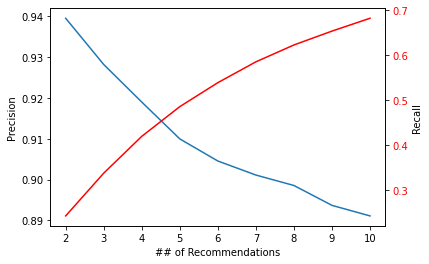

In [46]:
Recc=[]
Precision=[]
Recall=[]
for i in range(0,9):
    Recc.append(result[i]['K'])
    Precision.append(result[i]['Precision'])
    Recall.append(result[i]['Recall'])

from matplotlib import pyplot as plt
plt.plot(Recc, Precision)
plt.xlabel('## of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Recc, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')
  